In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import math


In [34]:
BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

data_root  = "mega_batch"               # <-- your folder
full_ds    = datasets.ImageFolder(data_root, transform=transform)

# Calculate lengths for train, validation, and test splits
train_len = int(0.7 * len(full_ds))
val_len = int(0.1 * len(full_ds))
test_len = len(full_ds) - train_len - val_len  # Remaining samples for the test set

# Split the dataset
train_set, val_set, test_set = random_split(full_ds, [train_len, val_len, test_len])

# Create DataLoaders for each set
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Class mapping:", full_ds.class_to_idx              # Option A
      if isinstance(train_set, torch.utils.data.Subset)   
      else train_set.class_to_idx)     

Class mapping: {'lebron': 0, 'other': 1}


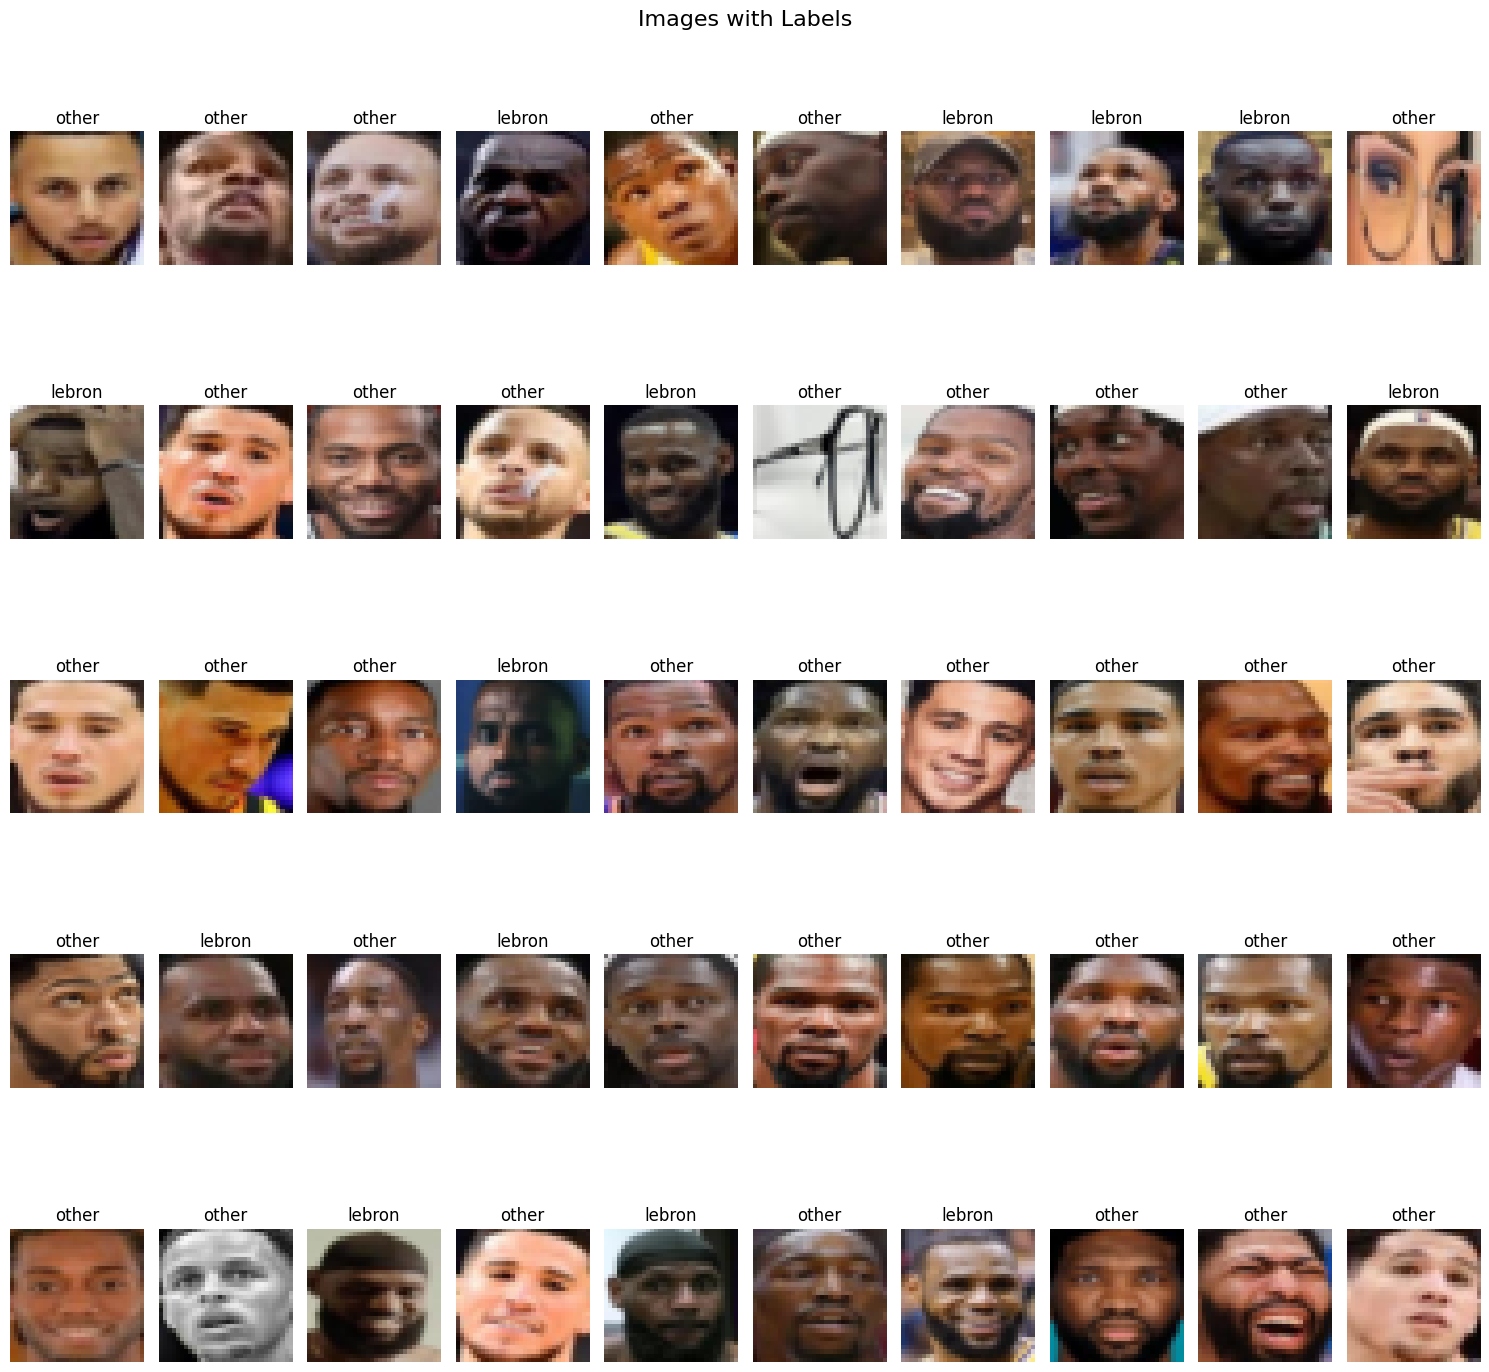

In [36]:
import matplotlib.pyplot as plt

def display_training_images(dataset, idx_to_class, num_images=10, images_per_row=10):
    """
    Displays images from the training set with their corresponding labels.

    Parameters:
    - dataset: The dataset (e.g., train_set).
    - idx_to_class: A dictionary mapping class indices to class names.
    - num_images: Number of images to display.
    """
    num_rows = math.ceil(num_images / images_per_row)  # Calculate the number of rows
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    fig.suptitle("Images with Labels", fontsize=16)

    for i in range(num_images):
        row = i // images_per_row
        col = i % images_per_row
        img, label = dataset[i]  # Get image and label
        img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Unnormalize the image

        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(idx_to_class[label])

    # Hide unused axes
    for i in range(num_images, num_rows * images_per_row):
        row = i // images_per_row
        col = i % images_per_row
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display images
display_training_images(test_set, idx_to_class, num_images=50)

In [3]:
from collections import Counter

# Function to calculate class distribution
def get_class_distribution(dataset):
    targets = [label for _, label in dataset]
    return Counter(targets)

# Print class distribution for each dataset
print("Class distribution in Training set:", get_class_distribution(train_set))
print("Class distribution in Validation set:", get_class_distribution(val_set))
print("Class distribution in Test set:", get_class_distribution(test_set))

Class distribution in Training set: Counter({1: 810, 0: 266})
Class distribution in Validation set: Counter({1: 116, 0: 37})
Class distribution in Test set: Counter({1: 240, 0: 69})


In [4]:
class SimpleBinaryCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),          # 64×8×8 = 4096
            nn.Linear(4096, 256), nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 1)      # <-- single output logit
        )

    def forward(self, x):
        return self.classifier(self.features(x))


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = SimpleBinaryCNN().to(device)

criterion = nn.BCEWithLogitsLoss()       # <-- binary
optimizer = optim.Adam(model.parameters(), lr=1e-3)


cuda


# Training

In [6]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct = 0.0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_set)
    train_acc = correct / len(train_set)

    # --- quick validation ---
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
            logits = model(imgs)
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == labels).sum().item()
    val_acc = val_correct / len(val_set)

    # --- test evaluation ---
    test_correct = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
            logits = model(imgs)
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == labels).sum().item()
    test_acc = test_correct / len(test_set)

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"train_loss: {train_loss:.3f} | train_acc: {train_acc:.3f} | "
          f"val_acc: {val_acc:.3f} | test_acc: {test_acc:.3f}")

Epoch 1/20 | train_loss: 0.506 | train_acc: 0.744 | val_acc: 0.778 | test_acc: 0.799
Epoch 2/20 | train_loss: 0.371 | train_acc: 0.838 | val_acc: 0.869 | test_acc: 0.874
Epoch 3/20 | train_loss: 0.330 | train_acc: 0.853 | val_acc: 0.882 | test_acc: 0.835
Epoch 4/20 | train_loss: 0.318 | train_acc: 0.867 | val_acc: 0.882 | test_acc: 0.903
Epoch 5/20 | train_loss: 0.258 | train_acc: 0.898 | val_acc: 0.902 | test_acc: 0.874
Epoch 6/20 | train_loss: 0.235 | train_acc: 0.907 | val_acc: 0.922 | test_acc: 0.909
Epoch 7/20 | train_loss: 0.200 | train_acc: 0.924 | val_acc: 0.895 | test_acc: 0.913
Epoch 8/20 | train_loss: 0.165 | train_acc: 0.940 | val_acc: 0.915 | test_acc: 0.922
Epoch 9/20 | train_loss: 0.155 | train_acc: 0.944 | val_acc: 0.922 | test_acc: 0.922
Epoch 10/20 | train_loss: 0.119 | train_acc: 0.959 | val_acc: 0.935 | test_acc: 0.942
Epoch 11/20 | train_loss: 0.117 | train_acc: 0.954 | val_acc: 0.935 | test_acc: 0.939
Epoch 12/20 | train_loss: 0.139 | train_acc: 0.950 | val_acc: 0

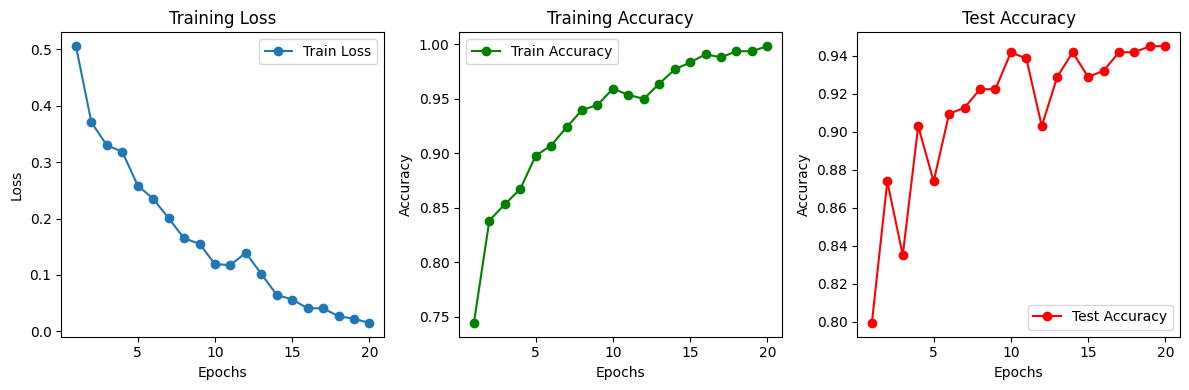

In [8]:
# Plot training loss, training accuracy, and test accuracy
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

# Plot test accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Predict

In [59]:
from PIL import Image
import torch

# Reverse lookup so 0/1 → folder names (only if you want the class string)
idx_to_class = {v: k for k, v in train_set.dataset.class_to_idx.items()}
# └─ If you used the train/val sub-folder layout, swap `full_ds.dataset` for `train_set.dataset`

def predict_image(path: str,
                  model: torch.nn.Module = model,
                  transform=transform,
                  device: str = "cuda" if torch.cuda.is_available() else "cpu",
                  threshold: float = 0.5):
    """
    Runs a single-image prediction on a *binary* CNN.

    Returns
    -------
    dict
        A dictionary with keys:
        - 'probability' (float): P(class == 1)
        - 'label_idx' (int): 0 or 1
        - 'label_name' (str): Folder name if `idx_to_class` is defined.
        - 'class_probabilities' (dict): Probabilities for both classes.
    """
    # 1. Pre-process
    img = Image.open(path).convert("RGB")
    img.resize((128,128), Image.LANCZOS)  # Resize to match training size
    tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

    # 2. Forward pass
    model.eval()
    with torch.no_grad():
        logit = model(tensor)  # shape [1, 1]
        prob = torch.sigmoid(logit).item()

    # 3. Post-process
    label_idx = int(prob > threshold)
    label_name = idx_to_class.get(label_idx, str(label_idx))

    # Class probabilities
    class_probabilities = {
        "Lebron": prob,
        "Other": 1 - prob
    }

    return {
        "probability": prob,
        "label_idx": label_idx,
        "label_name": label_name,
        "class_probabilities": class_probabilities
    }

In [60]:
result = predict_image("lebleb.jpg")
print(f"Predicted class: {result['label_name']} "
      f"(p = {result['probability']:.2%})")
print("Class probabilities:")
for class_name, prob in result['class_probabilities'].items():
    print(f"  {class_name}: {prob:.2%}")

# if result['label_name'] == "lebron":
#     print(f"Lebron is detected, probability: {result['label_name']} {result['probability']:.2%}")
# else:
#     print(f"Lebron is not detected, probability: {result['label_name']} {result['probability']:.2%}")

Predicted class: lebron (p = 1.55%)
Class probabilities:
  Lebron: 1.55%
  Other: 98.45%
